# 📑 Resume Classification using Machine Learning  

This project classifies resumes into different **job categories** using **NLP** and **Machine Learning**.  
We preprocess text data, vectorize using **TF-IDF**, train multiple models, and save the best one for predictions.  

---

## 1. Import Required Libraries 

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 

## 2) Load the Dataset
**Goal:** Read the resume dataset into memory.  
**What happens:** Load the CSV containing two key columns: `Resume` (free‑text) and `Category` (target label).  
**Why it matters:** Everything downstream depends on clean access to the raw data.


In [65]:
df = pd.read_csv('../data/UpdatedResumeDataSet.csv')

## 3) Quick Data Peek
**Goal:** Validate data integrity at a glance.  
**What happens:** View random samples, row/column counts, and basic info to confirm expected structure and spot obvious issues (empty rows, encoding quirks).  
**Why it matters:** Early checks prevent wasted time training on broken data.

In [66]:
df.sample(5)

,Category,Resume
567,Python Developer,Training attended: 1. Successfully completed E...
457,Automation Testing,TECHNICAL SKILLS Automation Testing â¢ Seleni...
761,Hadoop,"Technical Skills Programming Languages: C, C++..."
602,DevOps Engineer,Technical Skills Key Skills MS Technology .Net...
629,DevOps Engineer,CORE COMPETENCIES ~ Ant ~ Maven ~ GIT ~ Bitbuc...


In [67]:
df.shape

(962, 2)

## 4) Category Distribution (Counts)
**Goal:** Understand label imbalance.  
**What happens:** Calculate how many resumes fall into each category; visualize as a bar chart.  
**Why it matters:** Class imbalance can bias models toward dominant classes, hurting real‑world performance.

---

In [68]:
df['Category'].value_counts()

Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Mechanical Engineer          40
ETL Developer                40
Blockchain                   40
Operations Manager           40
Arts                         36
Database                     33
Health and fitness           30
PMO                          30
Electrical Engineering       30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: count, dtype: int64

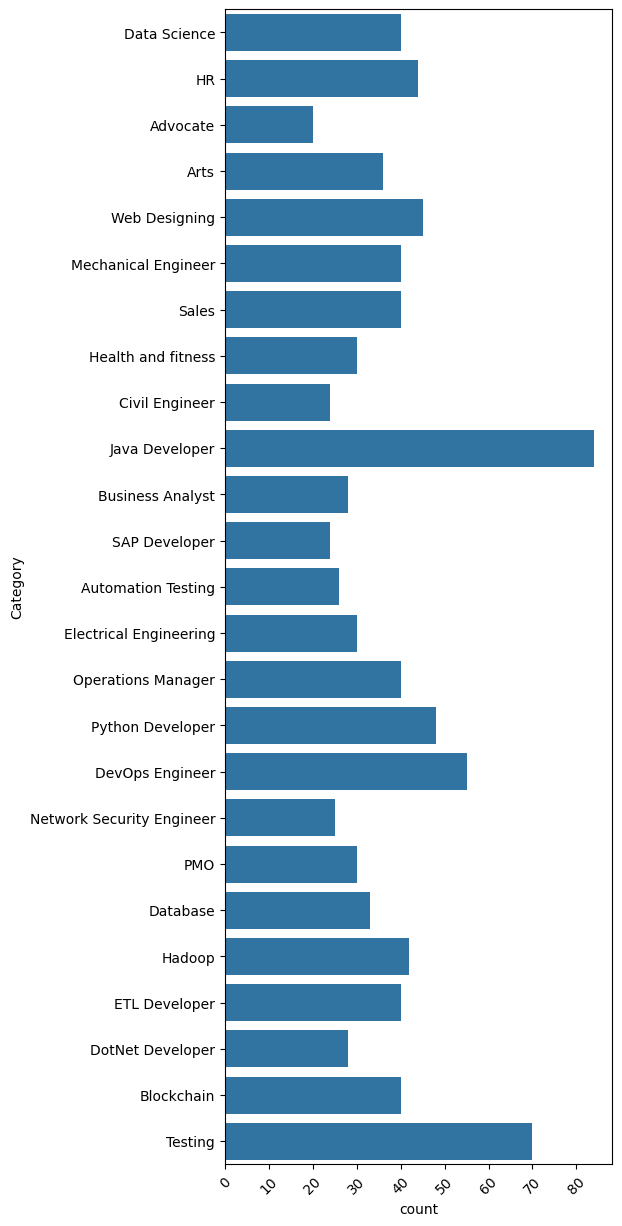

In [69]:
plt.figure(figsize=(5,15))
sns.countplot(df['Category'])
plt.xticks(rotation=45)
plt.show()

In [70]:
df['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

## 5) Category Distribution (Share/Pie)
**Goal:** See proportional representation.  
**What happens:** Plot the share of each category to complement the count view.  
**Why it matters:** Proportions reveal if any class is severely underrepresented and needs balancing.


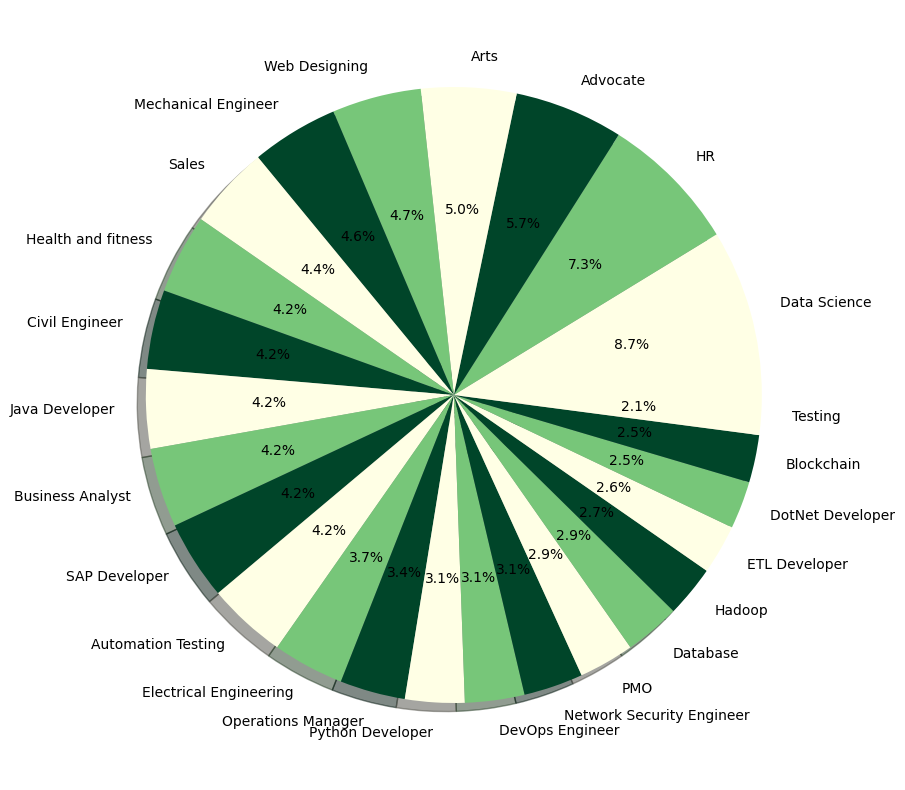

In [71]:
counts = df['Category'].value_counts()
labels = df['Category'].unique()
plt.figure(figsize=(15,10))

plt.pie(counts,labels=labels,autopct='%1.1f%%',shadow=True, colors=plt.cm.YlGn(np.linspace(0,1,3)))
plt.show()

In [72]:
df['Category'][0]

'Data Science'

In [73]:
df['Resume'][0]

'Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling (LDA, NMF), PCA & Neural Nets. * Database Visualizations: Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib, ggplot, Tableau. * Others: Regular Expression, HTML, CSS, Angular 6, Logstash, Kafka, Python Flask, Git, Docker, computer vision - Open CV and understanding of Deep learning.Education Details \r\n\r\nData Science Assurance Associate \r\n\r\nData Science Assurance Associate - Ernst & Young LLP\r\nSkill Details \r\nJAVASCRIPT- Exprience - 24 months\r\njQuery- Exprience - 24 months\r\nPython- Exprience - 24 monthsCompany Details \r\ncompany - Ernst & Young LLP\r\ndescription - Fraud Investigatio

## 6) Balance the Dataset (Oversampling)
**Goal:** Reduce label imbalance to improve model fairness.  
**What happens:** Use class‑wise oversampling so every category has the same number of examples (by resampling with replacement).  
**Why it matters:** Balanced training reduces bias and usually improves macro‑average metrics.  
> 🔎 *Caution:* Oversampling can overfit to duplicated texts. Consider alternatives (class weights, augmentation) during iteration.


In [74]:
print("Original Category Distribution:")
print(df['Category'].value_counts())

max_size = df['Category'].value_counts().max()

balanced_df = df.groupby('Category').apply(lambda x: x.sample(max_size, replace=True)).reset_index(drop=True)

df = balanced_df.sample(frac=1).reset_index(drop=True)

print("\nBalanced Category Distribution (After Oversampling):")
print(df['Category'].value_counts())

Original Category Distribution:
Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Mechanical Engineer          40
ETL Developer                40
Blockchain                   40
Operations Manager           40
Arts                         36
Database                     33
Health and fitness           30
PMO                          30
Electrical Engineering       30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: count, dtype: int64

Balanced Category Distribution (After Oversampling):
Category
Testing                      84
Automation Testing           84
Arts  

/tmp/ipykernel_10871/3152747445.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('Category').apply(lambda x: x.sample(max_size, replace=True)).reset_index(drop=True)


## 7) Clean the Text
**Goal:** Normalize and denoise resume text.  
**What happens:** Remove URLs, hashtags, mentions, and punctuation; collapse extra spaces. Keep words that carry meaning.  
**Why it matters:** Cleaner text → clearer signal for the vectorizer and models.


In [75]:
import re

def clean_text(txt):
    cleanText = re.sub(r"http\S+\s", " ", txt)
    cleanText = re.sub(r"#\S+\s", " ", cleanText)
    cleanText = re.sub(r"@\S+", "  ", cleanText)
    cleanText = re.sub("[%s]" % re.escape("!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"), " ", cleanText)
    cleanText = re.sub(r"\s+", " ", cleanText)
    return cleanText


In [76]:
cleanResume("my #### $ #  #noorsaeed webiste like is this http://heloword and access it @gmain.com")

'my webiste like is this and a ess it '

In [77]:
df['Resume'] = df['Resume'].apply(lambda x: cleanResume(x))

In [78]:
df['Resume'][0]

'COMPUTER SKILLS SOFTWARE KNOWLEDGE MS Power Point MS Office C Protius PCB Design Multisim Micro wind Matlab Keil Latex Basic I nternet Fundamentals Software and Hardware Knowledge PROJECT DETAILS Diploma Project Speed Control of DC Motor Using Heart Beats Mini Project Water Gardening System Using Solar Panel Final Year BE Project Iris Recognition system Education Details January 2016 BE EDUCATION Pune Maharashtra PUNE University January 2010 SSC Maharashtra Board Quality Engineer Quality Engineer Matrix Technologies Skill Details MATLAB Exprience 6 months PCB Exprience 6 months PCB DESIGN Exprience 6 monthsCompany Details company Matrix Technologies description company RB Electronics description '

## 8) Encode Target Labels
**Goal:** Convert human‑readable categories into machine‑readable IDs.  
**What happens:** Map each unique category (e.g., “Data Science”, “HR”) to an integer label. Save the encoder for later inference.  
**Why it matters:** Most classifiers require numeric targets; consistency between train and inference is critical.


In [79]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [80]:
le.fit(df['Category'])
df['Category'] = le.transform(df['Category'])

In [81]:
df.Category.unique()

array([23,  2,  1, 12, 18,  9, 10,  8, 11, 15, 21,  0, 13, 17, 24,  7,  4,
       22, 16, 20, 19, 14,  3,  5,  6])

## 9) Feature Extraction with TF‑IDF
**Goal:** Turn text into numeric features.  
**What happens:** Build a TF‑IDF vocabulary on the training resumes and transform each resume into a sparse feature vector.  
**Why it matters:** TF‑IDF highlights informative terms while down‑weighting ubiquitous words, giving models a strong baseline representation.


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

tfidf.fit(df['Resume'])
requredTaxt  = tfidf.transform(df['Resume'])

## 10) Train/Test Split
**Goal:** Evaluate generalization honestly.  
**What happens:** Split data into training (e.g., 80%) and testing (20%) with a fixed random seed for reproducibility.  
**Why it matters:** Prevents “training on the test set” and ensures reported metrics reflect real‑world performance.


In [83]:
from sklearn.model_selection import train_test_split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(requredTaxt, df['Category'], test_size=0.2, random_state=42)

In [85]:
X_train.shape

(1680, 7280)

In [86]:
X_test.shape

(420, 7280)

## 11) Train Multiple Models & Compare
**Goal:** Find the best baseline model.  
**What happens:** Fit several classifiers (e.g., KNN, SVM, Random Forest) and compare on accuracy, macro F1, and confusion matrices.  
**Why it matters:** Different models capture different decision boundaries; SVM with TF‑IDF often performs strongly for text classification.  
> 💡 *Tip:* Track results with a small leaderboard table and keep confusion matrix heatmaps for story‑telling.


In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
X_test = X_test.toarray() if hasattr(X_test, 'toarray') else X_test

knn_model = OneVsRestClassifier(KNeighborsClassifier())
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print("\nKNeighborsClassifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_knn)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_knn)}")


KNeighborsClassifier Results:
Accuracy: 0.9952
Confusion Matrix:
[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   1]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  

In [88]:

svc_model = OneVsRestClassifier(SVC())
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
print("\nSVC Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_svc)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svc)}")


SVC Results:
Accuracy: 1.0000
Confusion Matrix:
[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0 

In [89]:
rf_model = OneVsRestClassifier(RandomForestClassifier())
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandomForestClassifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_rf)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_rf)}")


RandomForestClassifier Results:
Accuracy: 1.0000
Confusion Matrix:
[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0

## 12) Persist Artifacts
**Goal:** Make the system reproducible and deployable.  
**What happens:** Save the **trained classifier**, **TF‑IDF vectorizer**, and **label encoder** to disk (e.g., `clf.pkl`, `tfidf.pkl`, `encoder.pkl`).  
**Why it matters:** Inference must use the exact same preprocessing and mappings as training.


In [90]:
import pickle
import os

save_dir = "../data"

os.makedirs(save_dir, exist_ok=True)

# Save files
with open(os.path.join(save_dir, "clf.pkl"), "wb") as f:
    pickle.dump(svc_model, f)

with open(os.path.join(save_dir, "tfidf.pkl"), "wb") as f:
    pickle.dump(tfidf, f)

with open(os.path.join(save_dir, "encoder.pkl"), "wb") as f:
    pickle.dump(le, f)


## 13) Inference Pipeline (Predict Function)
**Goal:** Classify any new resume.  
**What happens:** Apply the same cleaning → transform text with saved TF‑IDF → predict with the saved model → map numeric label back to the original category.  
**Why it matters:** Encapsulates the full logic into a single, reusable function used by apps/APIs.


In [91]:
def pred(input_resume):
    
    cleaned_text = cleanResume(input_resume) 

    vectorized_text = tfidf.transform([cleaned_text])
       
    vectorized_text = vectorized_text.toarray()

    predicted_category = svc_model.predict(vectorized_text)

    predicted_category_name = le.inverse_transform(predicted_category)

    return predicted_category_name[0]  

## 14) Demo & Next Steps
**Goal:** Validate end‑to‑end and plan improvements.  
**What happens:** Run a sample resume through the pipeline and review the predicted category. Consider upgrades:  
- 🔁 **Data:** Add more diverse resumes; reduce duplicates.  
- ⚖️ **Imbalance:** Try class weights / smarter sampling.  
- 🧠 **Features:** N‑grams, domain stopwords, or embeddings (e.g., fastText, transformer encoders).  
- 🧪 **Models:** Linear SVM with calibration, Logistic Regression, or modern transformer fine‑tuning.  
- 🚀 **Productization:** Wrap with Streamlit/Flask API; add file upload (PDF/DOCX) and keyword gap analysis against JD.


In [92]:
myresume = """I am a data scientist specializing in machine
learning, deep learning, and computer vision. With
a strong background in mathematics, statistics,
and programming, I am passionate about
uncovering hidden patterns and insights in data.
I have extensive experience in developing
predictive models, implementing deep learning
algorithms, and designing computer vision
systems. My technical skills include proficiency in
Python, Sklearn, TensorFlow, and PyTorch.
What sets me apart is my ability to effectively
communicate complex concepts to diverse
audiences. I excel in translating technical insights
into actionable recommendations that drive
informed decision-making.
If you're looking for a dedicated and versatile data
scientist to collaborate on impactful projects, I am
eager to contribute my expertise. Let's harness the
power of data together to unlock new possibilities
and shape a better future.
Contact & Sources
Email: 611noorsaeed@gmail.com
Phone: 03442826192
Github: https://github.com/611noorsaeed
Linkdin: https://www.linkedin.com/in/noor-saeed654a23263/
Blogs: https://medium.com/@611noorsaeed
Youtube: Artificial Intelligence
ABOUT ME
WORK EXPERIENCE
SKILLES
NOOR SAEED
LANGUAGES
English
Urdu
Hindi
I am a versatile data scientist with expertise in a wide
range of projects, including machine learning,
recommendation systems, deep learning, and computer
vision. Throughout my career, I have successfully
developed and deployed various machine learning models
to solve complex problems and drive data-driven
decision-making
Machine Learnine
Deep Learning
Computer Vision
Recommendation Systems
Data Visualization
Programming Languages (Python, SQL)
Data Preprocessing and Feature Engineering
Model Evaluation and Deployment
Statistical Analysis
Communication and Collaboration
"""

pred(myresume)

'Data Science'

In [93]:
myresume = """
Jane Smith is a certified personal trainer with over 5 years of experience in helping individuals achieve their fitness goals. Specializing in weight loss, strength training, and sports conditioning, Jane has developed personalized workout routines for clients of all ages and fitness levels. She has extensive knowledge in nutrition and exercise science, and uses this to create holistic health and fitness programs that are tailored to individual needs.

Jane holds a degree in Exercise Science and is a certified trainer through the National Academy of Sports Medicine (NASM). She has worked with athletes, seniors, and individuals with chronic health conditions, helping them improve their physical well-being and overall quality of life.

Her expertise includes:
- Weight Loss and Body Composition
- Strength Training and Resistance Exercises
- Cardio Conditioning
- Nutrition Coaching and Meal Planning
- Injury Prevention and Rehabilitation
- Functional Movement and Flexibility Training
- Group Fitness Classes

Certifications:
- Certified Personal Trainer, NASM
- CPR and First Aid Certified
- Yoga Instructor (200-Hour Certification)

Education:
BSc in Exercise Science, ABC University, 2014-2018

Work Experience:
- Personal Trainer at XYZ Fitness Gym (2018-Present)
- Fitness Coach at Wellness Center (2016-2018)

Languages:
- English (Fluent)
- Spanish (Conversational)
"""


pred(myresume)

'Health and fitness'

In [94]:
myresume = """
John Doe is an experienced Network Security Engineer with over 7 years of expertise in designing, implementing, and managing network security infrastructures. Specializing in safeguarding critical network systems, John has worked with various organizations to protect against cyber threats, data breaches, and unauthorized access. He is proficient in deploying firewalls, intrusion detection systems (IDS), VPNs, and network monitoring tools to ensure the integrity and security of networks.

John holds a degree in Computer Science and certifications in several cybersecurity domains, including Certified Information Systems Security Professional (CISSP), Certified Ethical Hacker (CEH), and Cisco Certified Network Associate (CCNA). He has extensive experience in troubleshooting and resolving network vulnerabilities, and has played a key role in conducting security audits and risk assessments.

Key Skills:
- Network Security Architecture
- Firewall Management and Configuration
- Intrusion Detection and Prevention Systems (IDS/IPS)
- Virtual Private Networks (VPNs)
- Security Audits and Risk Assessments
- Cybersecurity Incident Response
- Network Monitoring and Traffic Analysis
- Vulnerability Assessment and Penetration Testing
- Data Encryption and Secure Communications

Certifications:
- CISSP (Certified Information Systems Security Professional)
- CEH (Certified Ethical Hacker)
- CCNA (Cisco Certified Network Associate)
- CompTIA Security+

Education:
BSc in Computer Science, XYZ University, 2012-2016

Professional Experience:
- Network Security Engineer at ABC Corp (2016-Present)
- IT Security Specialist at DEF Solutions (2014-2016)

Languages:
- English (Fluent)
- French (Intermediate)
"""

pred(myresume)

'Network Security Engineer'

## 📦 Deliverables Checklist
- [x] Clean, balanced dataset  
- [x] Saved artifacts: `clf.pkl`, `tfidf.pkl`, `encoder.pkl`  
- [x] Inference function producing human‑readable categories  
- [x] Evaluation report with key metrics & confusion matrix

---

### 🧭 TL;DR (One‑Slide Summary)
**Clean → Balance → Vectorize → Train → Save → Predict.**  
A robust, reproducible pipeline for resume classification ready for app integration .